<a href="https://colab.research.google.com/github/foxtrotmike/RL-MagLev/blob/master/cat_mouse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A neural solution the cat and mouse puzzle 
## by Fayaz Minhas

---
In this notebook we will be developing a neural solution to the cat and mouse puzzle. For an introduction, please watch the [Video](https://youtu.be/N20h6vpR13Y)









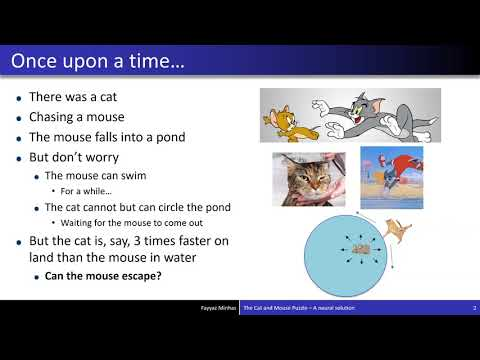

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('N20h6vpR13Y')

## The environment

We first develop the environment for our puzzle and test it. Please read the comments in the code for further understanding. 

[ 0.69346728  0.002       1.46356895 -0.83527899]


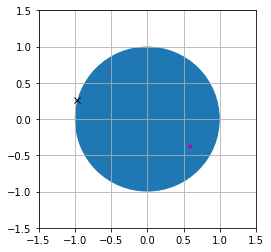

<Figure size 432x288 with 0 Axes>

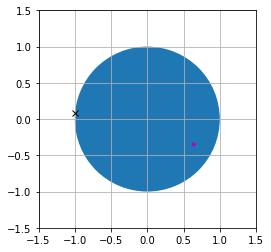

<Figure size 432x288 with 0 Axes>

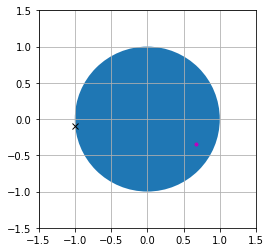

<Figure size 432x288 with 0 Axes>

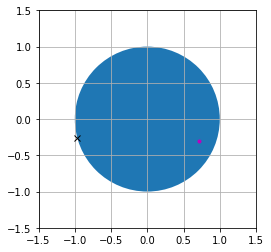

<Figure size 432x288 with 0 Axes>

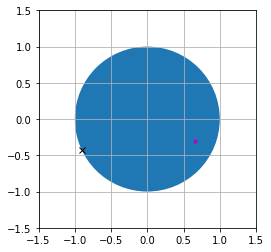

<Figure size 432x288 with 0 Axes>

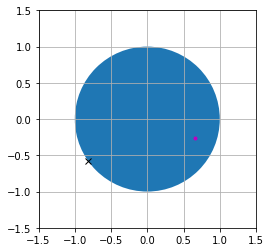

<Figure size 432x288 with 0 Axes>

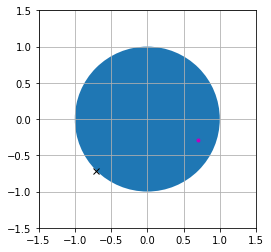

<Figure size 432x288 with 0 Axes>

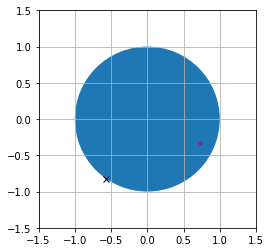

<Figure size 432x288 with 0 Axes>

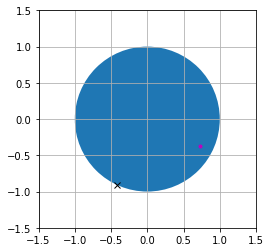

<Figure size 432x288 with 0 Axes>

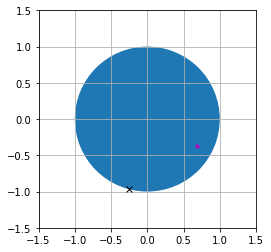

<Figure size 432x288 with 0 Axes>

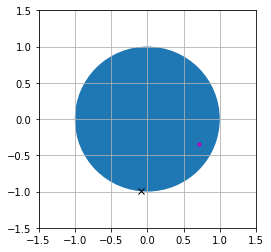

<Figure size 432x288 with 0 Axes>

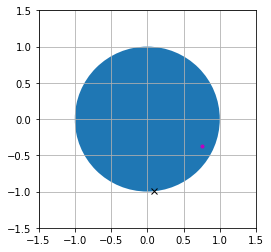

<Figure size 432x288 with 0 Axes>

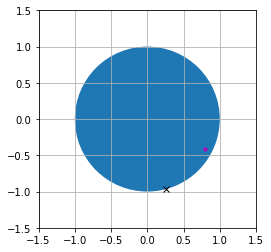

<Figure size 432x288 with 0 Axes>

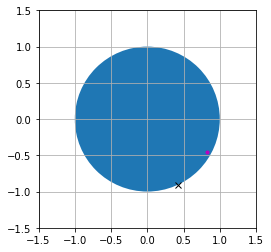

<Figure size 432x288 with 0 Axes>

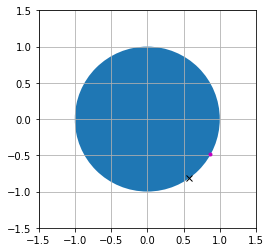

<Figure size 432x288 with 0 Axes>

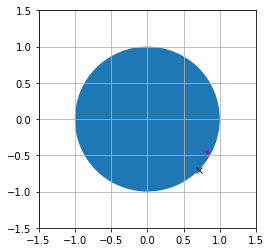

<Figure size 432x288 with 0 Axes>

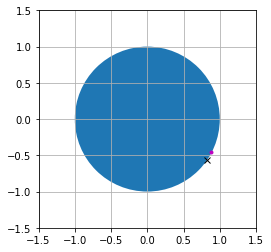

<Figure size 432x288 with 0 Axes>

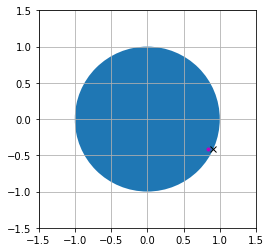

<Figure size 432x288 with 0 Axes>

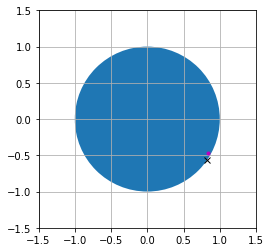

<Figure size 432x288 with 0 Axes>

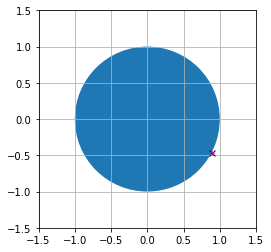

<Figure size 432x288 with 0 Axes>

(0, True, False, 0.958, 0.0031755205629940123)
1.961175520562994


In [2]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 13 15:22:11 2018
A simple example of a custom gym-style environment for the cat and mouse puzzle
@author: Fayyaz Minhas
"""

import logging
import numpy as np
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import random
from cmath import polar,rect
from math import pi,atan2,cos,sin

import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F


class CatMouse:
    
    def __init__(self):
        self.naction = 8 #number of directions 
        self.t = 0.0 #current time 
        self.m = 3.5 #advantage factor multiplier to the cat
        self.d = 0.05 #distance traveled by the mouse in one step
        self.T = 500.0 #max number of time steps before mouse drowns 
        self.R = 1.0 #radius of the pond
        
        self.lastAction = 0
        
        self.reset() #initialize parameters
        
    def step(self, action):
        """
        execute action
        """
        self._take_action(action)
        self.lastAction = action
        self.t+=1.0 #increment time
        reward = self._get_reward()
        obs = self._get_state()
        tc,pmx,pmy = self.tc,self.pm.real,self.pm.imag
        done = polar(self.pm)[0]>self.R or self.t>=(self.T-1) 
        #if mouse out of water or if time limit expired
    
        return obs, reward, done
        
    def reset(self):
        """
        Reset the state of the environment and returns an initial observation.
        Returns
        -------
        observation (object): the initial observation of the space.
        """       
        
        self.caught = False      
        self.init_mouse_cat_position()
        self.t=0 
        self.V = []
        
        return self._get_state()
    
    def init_mouse_cat_position(self,r=None,t=None,p=0.0,tc = None):   
        if r is None :
            r = self.R*np.random.rand()  
        if t is None:
            t = pi*(2*np.random.rand()-1) 
            
        self.pm = rect(r,t) #initial position of the mouse
        if tc is None:
            tc = pi*(2*np.random.rand()-1)
        self.tc = tc
        if r<p*self.R: #initialize cat to be closest to the mouse
            self.tc = t
        self.cat_old = None #used for render
        self.mouse_old = None #used for render
        return r,t,tc
        
    def render(self, figid = 0, persistent = False, video = False):
        """
        Shows a mouse and the cat.
        persistent retains previous positions
        """
        fig = plt.figure(figid);
        self.fig = fig
        ax=plt.gca()
        A = []
        #plt.ion()
        circle= plt.Circle((0,0), radius= self.R)
        pc = rect(self.R,self.tc)
        pm = self.pm
        
        if not persistent and not video:             ax.clear();
        ax.axis([-1.5,1.5,-1.5,1.5]);ax.grid();ax.set_aspect('equal', 'box');ax.add_patch(circle)
        
        if persistent and self.cat_old is not None:
            a, = ax.plot(self.cat_old.real,self.cat_old.imag,'cx')
            #A.append(a)
                  
        a, = ax.plot(pc.real,pc.imag,'kx')
        A.append(a)
        self.cat_old = pc      
        
        if persistent and self.mouse_old is not None:
            a, = ax.plot(self.mouse_old.real,self.mouse_old.imag,'y.')
            #A.append(a)
            
        a, = ax.plot(pm.real,pm.imag,'m.') 
        A.append(a)
        self.mouse_old = pm
        plt.pause(0.05); 
        plt.draw();plt.show()
        if video:
            self.V.append(tuple(A))
            
        return tuple(A)
        

    def _take_action(self, action):
        """
        Model the effect of the action taken and update state.
        Simple modeling of physics.
        """
        t = action*(2*np.pi/self.naction)
        self.pm+=rect(self.d,t) #new mouse position in rect
        rm,tm = polar(self.pm)        
            
        rc,tc = self.R,self.tc
        s = 2*(atan2(sin(tm-tc), cos(tm-tc))*180/pi>0)-1
        tc_new = tc+s*self.m*self.d/rc
        
        pc = rect(rc,tc)
        pc_new = rect(rc,tc_new)
        if rm>self.R: #if the point at which the mouse crosses out can be reached by the cat
            if abs(rect(self.R,tm)-pc)<abs(pc_new-pc):
                tc_new = tm
                self.caught = True     
        self.tc = tc_new
       
            
    def _get_state(self):        
        """Get the observation."""
        pc = rect(self.R,self.tc)
        rm = abs(self.pm)
        obs = np.asarray(list((rm,(self.t+1)/self.T,self.pm.real-pc.real,self.pm.imag-pc.imag))) 
        #mouse radial distance, heath (inv), direction vector to the cat
        return obs
            
    def isSucessful(self):
      tc,pmx,pmy = self.tc,self.pm.real,self.pm.imag
      pc = rect(self.R,tc) #position of the cat
      pm = complex(pmx,pmy) #position of the mouse
      dcm = polar(pm-pc)[0] #distance between cat and mouse
      outside = polar(pm)[0]>self.R #mouse outside?
      not_eaten = not(self.caught) 
      health = 1.0-(self.t+1)/self.T
      success = (health>=(1.0/self.T))*outside*not_eaten 
      return success,outside,not_eaten,health,dcm

    def _get_reward(self):
        """
        Reward function.
        """
        success,outside,not_eaten,health,dcm = self.isSucessful()
        reward = 3*success+dcm+health+outside+not_eaten+(not_eaten+0*health)*outside

        return reward
    
    def __str__(self):
        return str(self._get_state())
    def writeAnimation(self,fname='test.mp4'):
        from matplotlib import animation
        animation.rcParams['animation.writer'] = 'ffmpeg'
        ani = animation.ArtistAnimation(self.fig, self.V,interval =  50)
        ani.save(fname)

"""One can now create and environment and observe the effects of the actions as shown below."""
#%% Testing the environment
env = CatMouse()
s = env._get_state()
#env.m = 0.1
print(env)
F = []
plt.close('all')
fig = plt.figure(0)
for _ in range(100):
  a = np.random.randint(env.naction)
  obs, reward, done = env.step(a)
  env.render(0,video = True, persistent = False)
  if done:
    print(env.isSucessful())
    print(reward) 
    break
env.writeAnimation()


## Neural Network

Below we develop the neural network for implementing the Q-function Q(s,a). The select_action function implements the ($\epsilon$-greedy)  policy based on the Q function. It chooses random actions in the beginning and then uses the learned Q-function based policy. 

In [ ]:

#%% Neural network training

"""Below is the complete implementation of a Neural Q-learning algorithm. A neural Q-learning program will consist of three parts: environment, neural network and Q-learning. We have already implemented the environemtn. We use a simple neural network with 2 inputs (corresponding to the two state variables), 200 hidden neurons with ReLU activations and 2 outputs (corresponding to Q-values for each action). For details, see the neural network class implementation below.  A single episode (executed by the run_episode function) consists of 500 steps in whcih the environment is initialized (reset) and the actions are determined using an epsilon greedy policy with annealed epsilon values together with the neural network (see the select_action function). At each step, the neural network picks up 64 examples at random and uses them to learn the Q-function (see the learn function). The number of episodes is set to 70. It is important to note that the only information of the environment visible to neural network is the one given by the environment (position, velocity and reward). The internal workings of the environment are not visible to Q-learning. We have a Q-learning rate of 1.0 and a discount factor of 0.98 since the environment is deterministric. The target position is 5.0."""



# hyper parameters
EPISODES = 300  # number of episodes
EPS_START = 0.9  # e-greedy threshold start value
EPS_END = 0.05 # e-greedy threshold end value
EPS_DECAY = 10000  # e-greedy threshold decay
GAMMA = 0.85  # Q-learning discount factor
LR = 0.0025  # NN optimizer learning rate
BATCH_SIZE = 128  # Q-learning batch size

# if gpu is to be used
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

env = CatMouse()

class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            del self.memory[0]

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class Network(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(env._get_state().shape[0], 64)
        #self.l2 = nn.Linear(24, 16)
        self.l3 = nn.Linear(64, env.naction)

    def forward(self, x):
        x = torch.tanh(self.l1(x))
        #x = F.tanh(self.l2(x))
        x = (self.l3(x))
        return x
    
def select_action(model,state,eps_threshold = None):
    global steps_done
    sample = random.random()
    if eps_threshold is None:
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return model(Variable(state).type(FloatTensor)).data.max(1)[1].view(1, 1)
    else:
        return LongTensor([[random.randrange(env.naction)]])
steps_done = 0    


## Neural network training

Below is the code for training the neural network. It uses a memory buffer to store the state information and rewards which is then sampled by the neural network during training. 

In [ ]:
#%%
model = Network()
if use_cuda:
    model.cuda()
memory = ReplayMemory(10000)
optimizer = optim.Adam(model.parameters(), LR,weight_decay=5e-3)

episode_durations = []


def run_episode(e, environment):
    
    state = environment.reset()    
    steps = 0
    while True:
        steps += 1
        
        action = select_action(model,FloatTensor([state]))
        a = action.data.numpy()[0,0]
        next_state, reward, done = environment.step(a)
        


        memory.push((FloatTensor([state]),
                     action,  # action is already a tensor
                     FloatTensor([next_state]),
                     FloatTensor([reward])))

        learn()

        state = next_state

        if done:
            print(e,reward,environment.isSucessful())
            break
            


def learn():
    global GAMMA
    if len(memory) < BATCH_SIZE:
        return
    
    # random transition batch is taken from experience replay memory
    transitions = memory.sample(BATCH_SIZE)
    batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

    batch_state = Variable(torch.cat(batch_state))
    batch_action = Variable(torch.cat(batch_action))
    batch_reward = Variable(torch.cat(batch_reward))
    batch_next_state = Variable(torch.cat(batch_next_state))

    # current Q values are estimated by NN for all actions
    current_q_values = model(batch_state).gather(1, batch_action)
    # expected Q values are estimated from actions which gives maximum Q value
    max_next_q_values = model(batch_next_state).detach().max(1)[0]        

    expected_q_values = batch_reward + (GAMMA * max_next_q_values)

    # loss is measured from error between current and newly expected Q values
    loss = F.smooth_l1_loss(current_q_values, expected_q_values.view(BATCH_SIZE,1))

    # backpropagation of loss to NN
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



for e in range(EPISODES):
    run_episode(e, env)

print('Complete')
torch.save(model.state_dict(), 'catmouse_saved.mdl')
"""Once the learning is complete, we can test the performance of the neural network."""



## Testing

The code below loads a neural network and uses it to execute the learned policy. You can get a trained model from the [github page](https://github.com/foxtrotmike/RL-MagLev/). 

You can change the multiplier factor by changing the variable $env.m$ and enable visualization by setting $render = 1$. 

In [ ]:
#%%
model2 = Network()
model2.load_state_dict(torch.load('catmouse_864.mdl'))
model2.eval()
successes = 0
render = 1
persistent = 1
video = 0
Ntest = 500
for r in range(Ntest):           
    env = CatMouse()
    state = env.reset()
    env.m = 3.5
    
    r,t,tc = env.init_mouse_cat_position(r=0,t=0,tc = None)
    state = env._get_state()        
    
    Tmax = 500
    
    if render:
        plt.close('all')
        plt.figure(0)
    S = [[env.pm.real,env.pm.imag,env.tc]]
    while(1):                     
        if render: env.render(0,video = video, persistent = persistent) 
        a = select_action(model2,FloatTensor([state]),eps_threshold=0).data.numpy()[0,0]            
        state,reward,done = env.step(a)            
        print(env.t,state,a,reward,done)
        S.append([env.pm.real,env.pm.imag,env.tc])
        
        if done:
            ss = env.isSucessful()            
            successes+=ss[0]
            print(env.t,ss)
            if render: env.render(0,video = video, persistent = persistent)
            
            if ss[0]:
                if render and video:         env.writeAnimation()
                #1/0
            break
        if env.T-env.t<3 and env.t<Tmax: # if we want to go beyond env.T
            env.T+=1
    if render and video:         env.writeAnimation()
print(successes)        
print(env.isSucessful())
#%%



## Policy visualization

The code below can be used for policy visualization.

In [ ]:
"""We can now plot the position vs. the steps for the test case."""

fig, ax = plt.subplots()
ax.set_ylim([0,1.2])
# plt.plot(S[:,0]); plt.xlabel('steps'); plt.label('position')

"""We can also plot the policy (the action being taken) in different regions of the state space and overlay the movement of the ball in the test case."""

#%% Plotting the policy in the state space.
pc = (0,1)
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
A = np.zeros((len(x),len(y)))
for i,xi in enumerate(x):
    for j,yi in enumerate(y):
        ri = np.sqrt(xi**2+yi**2)
        if ri<1.0:            
            a = select_action(model2,FloatTensor([[ri,0.99,xi-pc[0],yi-pc[1]]])).data.numpy()[0,0]
            A[i,j] = (a/env.naction)*2*pi*180/pi
plt.figure(3)
plt.contourf(x,y,A);
plt.xlabel("x"); plt.ylabel("y")
plt.colorbar()
1/0
# plt.scatter(S[:,0],S[:,1],c='r'); plt.plot(S[0,0],S[0,1],c = 'k', marker ='*'); plt.scatter(S[-1,0],S[-1,1],c = 'k', marker ='s')


